# Projet numérique de science des données - NOM 1 Prénom 1 et NOM 2 Prénom 2

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrés de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib
C:\Users\loris\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [10]:
import pandas as pd

In [11]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [12]:
df_public.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


### Extraction de la matrice de design et des étiquettes 

In [13]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

In [14]:
pos_indices = np.where(y_public==1)[0]
neg_indices = np.where(y_public==0)[0]

X_peupliers = X_public[pos_indices]
X_pins = X_public[neg_indices]

y_peupliers = y_public[pos_indices]
y_pins = y_public[neg_indices]

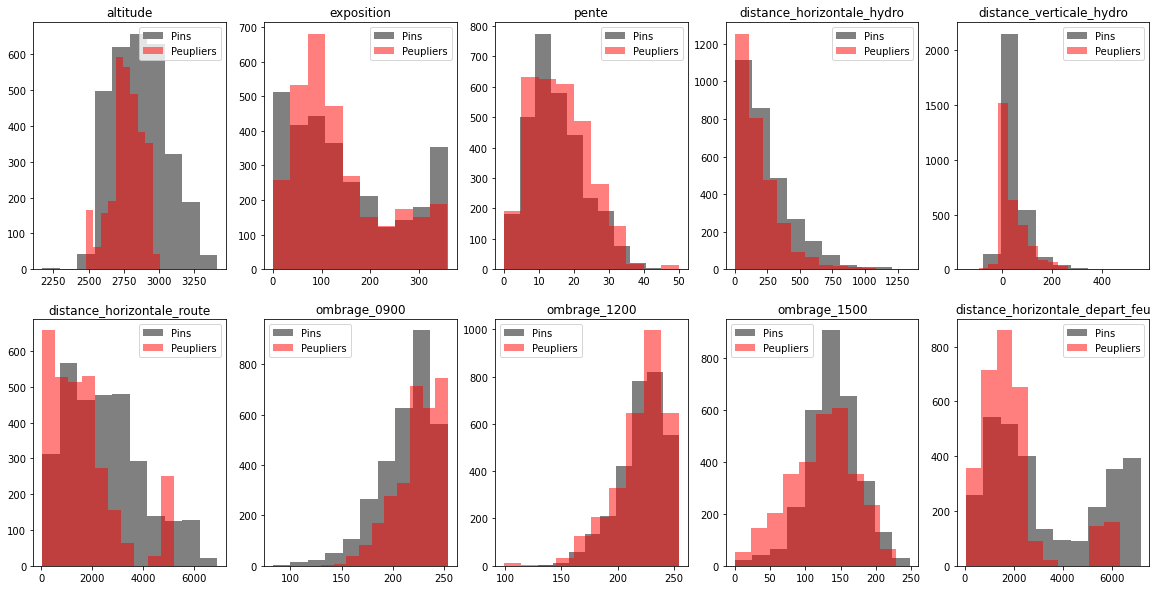

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

colonnes = list(df_public.columns)
k = 0

for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        variable = colonnes[k]
        ax.hist(X_pins[::, k], color="grey", label="Pins")
        ax.hist(X_peupliers[::, k], alpha=0.5, color="red", label="Peupliers")
        ax.legend()
        ax.set_title(variable)
        k = k + 1
plt.show()

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

Non, les histogrammes se superposent plutôt bien.

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

In [16]:
from sklearn import preprocessing

In [17]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)

StandardScaler()

In [18]:
X_public_preprocessed = standard_scaler.transform(X_public)

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [19]:
from sklearn import neighbors

In [20]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_public_preprocessed, y_public)

KNeighborsClassifier()

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

Pour un modèle de classification, on définit les deux grandeurs suivantes :
- sa précision : $$p = \frac{\text{nombre de vrais positifs}}{\text{nombre d'individus classés positifs}}$$
- son rappel : $$r = \frac{\text{nombre de vrais positifs}}{\text{nombre d'individus positifs}}$$
- son F-score : $$F = 2 \cdot \frac{rp}{r+p}$$

Dans notre cas, un modèle naïf prédisant systématiquement la classe positive aurait une précision $p = 0,5$, un rappel $r = 1$, et donc un F-score $F = \frac{2}{3}$.

#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [21]:
from sklearn.metrics import f1_score

In [22]:
y_pred = neigh.predict(X_public_preprocessed)
print(f1_score(y_public, y_pred))

0.9290079924776682


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

Le F-score de notre modèle est bon, cependant ce n'est pas une bonne idée d'évaluer notre modèle sur le jeu avec lequel il a été construit (il aura forcément un bon score sur ce jeu particulier).

Pour k=1, on voit que le modèle sera parfait sur le jeu d'entraînement, car pour chaque $x$, la fonction de décision sera la proportion d'individus d'étiquette positive parmi les 1 plus proches voisins de $x$ dans le jeu d'entraînement. En particulier, pour les $x$ présents dans le jeu d'entraînement, le seul voisin exploré est $x$. Les éléments $x$ du jeu d'entraînement seront donc classés correctement par notre modèle, et en évaluant notre modèle sur le jeu d'entraînement, on n'obtient pas d'information sur la réelle performance du modèle.

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [23]:
from sklearn import model_selection

In [24]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
X_train.shape, X_test.shape

((4800, 10), (1200, 10))

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [25]:
# Pré-traitement des variables
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train_preprocessed = standard_scaler.transform(X_train)

In [26]:
# Entraînement du modèle
neigh = neighbors.KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_preprocessed, y_train)

KNeighborsClassifier()

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [27]:
# Pré-traitement des variables
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_test)
X_test_preprocessed = standard_scaler.transform(X_test)

In [28]:
y_pred = neigh.predict(X_test_preprocessed)
print(f1_score(y_test, y_pred))

0.9019908116385911


#### Question 9
Commentez le F-score obtenu ci-dessus.

Ce F-score est légèrement moins bon que lorsqu'on avait évalué le modèle sur le jeu d'entraînement. Cela signifie que notre modèle n'a pas surappris.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
predictor = neighbors.KNeighborsClassifier()
liste_n = np.arange(1, 40, 2) # on va chercher pour 1, 3, 5, ..., 37, 39 voisins

tuned_parameters = [{'n_neighbors': liste_n}]
nb_folds = 10
grid = GridSearchCV(predictor, tuned_parameters, cv=nb_folds, refit=False, scoring='f1')

grid.fit(X_train_preprocessed, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

print(f"Meilleur nombre de voisins : {liste_n[np.argmax(scores)]}\nF-score moyen pour ce nombre de voisins : {np.max(scores)}")

Meilleur nombre de voisins : 1
F-score moyen pour ce nombre de voisins : 0.9056090346268977


#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

Le score correspondant au nombre de voisin optimal (1) est 0.91.

#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [31]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_preprocessed, y_train)
y_pred = neigh.predict(X_test_preprocessed)
print(f1_score(y_test, y_pred))

0.9132492113564669


## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logis = LogisticRegression(penalty="none")
logis.fit(X_train_preprocessed, y_train)

LogisticRegression(penalty='none')

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [34]:
y_logis_pred = logis.predict(X_test_preprocessed)
print(f1_score(y_test, y_logis_pred))

0.776954732510288


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

Évaluons d'abord le F-score de cette régression logistique sur le jeu d'entraînement.

In [35]:
print(f1_score(y_train, logis.predict(X_train_preprocessed)))

0.7724933086267243


On obtient un F-score proche du score précédent. Notre modèle sous-apprend, donc une régularisation l2 n'améliorera pas les performances du modèle (cette régularisation étant utile en cas de surapprentissage, ce qui n'est pas le cas ici).

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [36]:
# Ici on cherche pour C compris entre 1 et 1000 avec un pas de 1.

predictor = LogisticRegression(penalty='l2')
liste_C = np.linspace(1, 1000, 1000)

tuned_parameters = [{'C': liste_C}]
nb_folds = 10
grid = GridSearchCV(predictor, tuned_parameters, cv=nb_folds, refit=False, scoring='f1')

grid.fit(X_train_preprocessed, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

print(f"Meilleur valeur de C : {liste_C[np.argmax(scores)]}\nF-score moyen pour cette valeur de C : {np.max(scores)}")

Meilleur valeur de C : 19.0
F-score moyen pour cette valeur de C : 0.7707766776383049


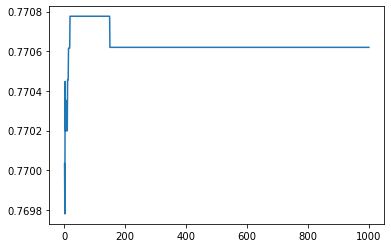

In [37]:
fig, ax = plt.subplots()

ax.plot(liste_C, scores)

plt.show()

On voit avec cette figure qu'on va chercher des valeurs de C inférieures à 200.

In [38]:
# Ici on cherche pour C compris entre 0.1 et 200 avec un pas de 0.1.

predictor = LogisticRegression(penalty='l2')
liste_C = np.linspace(0.1, 200, 2000)

tuned_parameters = [{'C': liste_C}]
nb_folds = 10
grid = GridSearchCV(predictor, tuned_parameters, cv=nb_folds, refit=False, scoring='f1')

grid.fit(X_train_preprocessed, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

print(f"Meilleur valeur de C : {liste_C[np.argmax(scores)]}\nF-score moyen pour cette valeur de C : {np.max(scores)}")

Meilleur valeur de C : 0.30000000000000004
F-score moyen pour cette valeur de C : 0.7715235859819303


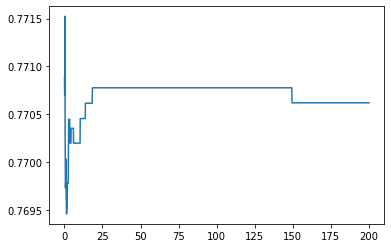

In [39]:
fig, ax = plt.subplots()

ax.plot(liste_C, scores)

plt.show()

On voit avec cette figure qu'on va chercher des valeurs de C inférieures à 1.

In [40]:
# Ici on cherche pour C compris entre 0.001 et 1 avec un pas de 0.001

predictor = LogisticRegression(penalty='l2')
liste_C = np.linspace(1e-3, 1e-0, 1000)

tuned_parameters = [{'C': liste_C}]
nb_folds = 10
grid = GridSearchCV(predictor, tuned_parameters, cv=nb_folds, refit=False, scoring='f1')

grid.fit(X_train_preprocessed, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

print(f"Meilleur valeur de C : {liste_C[np.argmax(scores)]}\nF-score moyen pour ce C : {np.max(scores)}")

Meilleur valeur de C : 0.28200000000000003
F-score moyen pour ce C : 0.7717727204544096


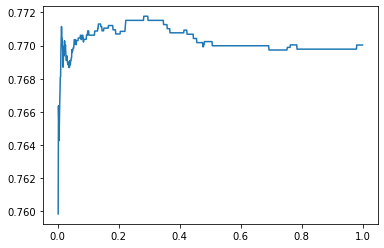

In [41]:
fig, ax = plt.subplots()

ax.plot(liste_C, scores)

plt.show()

In [42]:
# Ici on cherche pour C compris entre 0.0001 et 0.1 avec un pas de 0.0001

predictor = LogisticRegression(penalty='l2')
liste_C = np.linspace(1e-4, 1e-1, 1000)

tuned_parameters = [{'C': liste_C}]
nb_folds = 10
grid = GridSearchCV(predictor, tuned_parameters, cv=nb_folds, refit=False, scoring='f1')

grid.fit(X_train_preprocessed, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

print(f"Meilleur valeur de C : {liste_C[np.argmax(scores)]}\nF-score moyen pour ce C : {np.max(scores)}")

Meilleur valeur de C : 0.011899999999999999
F-score moyen pour ce C : 0.771150753182974


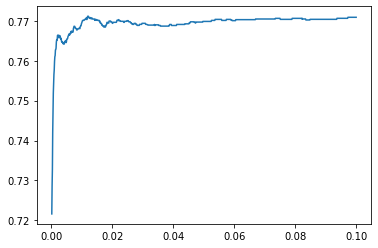

In [43]:
fig, ax = plt.subplots()

ax.plot(liste_C, scores)

plt.show()

On retiendra $C = 0.282$ comme valeur optimale de $C$.

#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [44]:
logis_opti = LogisticRegression(penalty='l2', C=0.282)
logis_opti.fit(X_train_preprocessed, y_train)
print(f1_score(y_test, logis_opti.predict(X_test_preprocessed)))

0.7792421746293247


#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Nous avions prévu que une régularisation l2 aurait peu d'impact sur la performance de notre modèle, et c'est bien le cas, le F-score a peu augmenté.

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
predictor = RandomForestClassifier()
liste_n = [1, 10, 100, 1000, 10000]

tuned_parameters = [{'n_estimators': liste_n}]
nb_folds = 10
grid = GridSearchCV(predictor, tuned_parameters, cv=nb_folds, refit=False, scoring='f1', verbose=3)

grid.fit(X_train_preprocessed, y_train)

scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

std_error = scores_std / np.sqrt(nb_folds)

print(f"Meilleur nombre d'arbres : {liste_n[np.argmax(scores)]}\nF-score moyen pour ce nombre d'arbres : {np.max(scores)}")

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END ................................n_estimators=1; total time=   0.0s
[CV 2/10] END ................................n_estimators=1; total time=   0.0s
[CV 3/10] END ................................n_estimators=1; total time=   0.0s
[CV 4/10] END ................................n_estimators=1; total time=   0.0s
[CV 5/10] END ................................n_estimators=1; total time=   0.0s
[CV 6/10] END ................................n_estimators=1; total time=   0.0s
[CV 7/10] END ................................n_estimators=1; total time=   0.0s
[CV 8/10] END ................................n_estimators=1; total time=   0.0s
[CV 9/10] END ................................n_estimators=1; total time=   0.0s
[CV 10/10] END ...............................n_estimators=1; total time=   0.0s
[CV 1/10] END ...............................n_estimators=10; total time=   0.0s
[CV 2/10] END ...............................n_e

In [1]:
fig, ax = plt.subplots()

ax.scatter(liste_n, scores)

plt.show()

NameError: name 'plt' is not defined

## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [ ]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.